# Jegadeesh-Titman Rolling Portfolios

_The future is simply the past that's waiting to happen_ - Unknown

Concepts:
- Price momentum
- Univariate spread portfolios
- Overlapping returns, Newey-West correction
- Hypothesis testing, size and power

References:

- Jegadeesh, Narasimhan, and Sheridan Titman (1993), "Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency". Journal of Finance. March 1993, Volume 48, Issue 1, Pages 65-91.

- Newey, Whitney K, West, Kenneth D (1987). "A Simple, Positive Semi-definite, Heteroskedasticity and Autocorrelation Consistent Covariance Matrix". Econometrica. 55 (3): 703–708.

- FRM Exam Book Part I Quantative Analysis Chapter 6


Copyright 2024, Terence Lim

MIT License

In [3]:
import math
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import scipy
from scipy.stats import kurtosis, skew, norm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.structured import BusDay, CRSP, CRSPBuffer
from finds.recipes import fractile_split
from finds.utils import plot_date
from secret import credentials, CRSP_DATE

In [2]:
VERBOSE = 0
#%matplotlib qt

In [3]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)

In [4]:
# date range and parameters to construct momentum portfolios
begrebal = 19260630                   # first price date is 19251231
endrebal = bd.endmo(CRSP_DATE, -1)    # last rebal is one month before last CRSP
rebaldates = bd.date_range(begrebal, endrebal, 'endmo')
percentiles = [20, 80]   # quintile spread percentile breakpoints
maxhold = 6    # hold each monthly-rebalanced portfolio for 6 months

In [5]:
# preload monthly dataset into memory
monthly = CRSPBuffer(stocks=crsp, dataset='monthly',
                     fields=['ret', 'retx', 'prc'],
                     beg=bd.begmo(rebaldates[0], -6),
                     end=bd.endmo(rebaldates[-1], 1))

## Price Momentum

### Overlapping portfolio returns

At the end of each month t, we construct the sorting variable as the investment
universe stocks' past 6 months returns. We determine the 20th and 80th
percentile of NYSE-listed stocks, then buy all stocks in top fractile
and short all stocks in the lowest fractile. The stocks are cap-weighted
within each fractile, while the spread portfolio is the equal-weighted
difference of the two sub-portfolios' returns. The spread portfolios' returns
over the next six months, expressed on a monthly basis by dividiving
by six, are recorded.

To be considered, a stock must be satisfy the usual investment universe criteria at the end of the rabalance month, and have non-missing month-end price six months ago.

In [6]:
stocks = monthly
mom = []
for rebaldate in tqdm(rebaldates):
    # determine pricing dates relative to rebaldate
    beg = bd.endmo(rebaldate, -6)   # require price at beg date
    end = bd.endmo(rebaldate, 0)    # require price at end date
    start = bd.offset(beg, 1)       # starting day of momemtum signal

    # retrieve universe, prices, and momentum signal
    p = [crsp.get_universe(rebaldate),
         stocks.get_ret(beg=start, end=end).rename('mom'),
         stocks.get_section(fields=['prc'], date=beg)['prc'].rename('beg')]
    df = pd.concat(p, axis=1, join='inner').dropna()

    # quintile breakpoints are determined from NYSE subset
    tritile = fractile_split(values=df['mom'],
                             pct=percentiles,
                             keys=df.loc[df['nyse'], 'mom'])

    # construct cap-wtd tritile spread portfolios
    porthi, portlo = [df.loc[tritile==t, 'cap'] for t in [1, 3]]
    port =  pd.concat((porthi/porthi.sum(), -portlo/portlo.sum()))

    # compute and store cap-weighted average returns over (up to) maxhold periods
    begret = bd.offset(rebaldate, 1)
    nhold = min(maxhold, len(rebaldates) - rebaldates.index(rebaldate))
    endret = bd.endmo(begret, nhold - 1)   # if maxhold is beyond end date
    rets = monthly.get_ret(begret, endret)
    ret = rets.reindex(port.index).fillna(0.).mul(port, axis=0).sum()
    mom.append(float(ret) / nhold)

100%|██████████| 1170/1170 [02:12<00:00,  8.84it/s]


In [7]:
DataFrame({'mean': np.mean(mom), 'std': np.std(mom)}, index=['Overlapping Returns'])

,mean,std
Overlapping Returns,0.004303,0.024709


### Non-overlapping portfolio returns

At the end of each month t, a spread portfolio is constructed in the same way. 
However, the return recorded is the equal-weighted average of the following month's
return on six portfolios constructed between t and t-5 (inclusive). After each 
month, the stock weights on the spread portfolios are adjusted for their
stocks' (split-adjusted) price change over the month, i.e. "buy-and-hold" over six months.


In [8]:
ports = []  # to roll 6 past portfolios
jt = []
stocks = monthly
for rebaldate in tqdm(rebaldates):
    
    # determine returns dates relative to rebaldate
    beg = bd.endmo(rebaldate, -6)   # require price at beg date
    end = bd.endmo(rebaldate, 0)    # require price at end date
    start = bd.offset(beg, 1)       # starting day of momemtum signal
    
    # retrieve universe, prices, and momentum signal
    p = [crsp.get_universe(rebaldate),
         stocks.get_ret(beg=start, end=end).rename('mom'),
         stocks.get_section(fields=['prc'], date=beg)['prc'].rename('beg')]
    df = pd.concat(p, axis=1, join='inner').dropna()
    
    # quintile breakpoints determined from NYSE subset
    tritile = fractile_split(values=df['mom'],
                             pct=percentiles,
                             keys=df.loc[df['nyse'], 'mom'])

    # construct cap-wtd tritile spread portfolios
    porthi, portlo = [df.loc[tritile==t, 'cap'] for t in [1, 3]]
    port =  pd.concat((porthi/porthi.sum(), -portlo/portlo.sum()))

    # retain up to 6 prior months of monthly-rebalanced portfolios
    ports.insert(0, port)
    if len(ports) > maxhold:
        ports.pop(-1)

    # compute all 6 portfolios' monthly capwtd returns, and store eqlwtd average
    begret = bd.offset(rebaldate, 1)
    endret = bd.endmo(begret)
    rets = stocks.get_ret(begret, endret)
    ret = np.mean([rets.reindex(p.index).fillna(0.).mul(p, axis=0).sum()
                   for p in ports])
    jt.append(ret)

    # adjust stock weights by monthly capital appreciation
    retx = stocks.get_ret(begret, endret, field='retx')
    ports = [(1 + retx.reindex(p.index).fillna(0.)).mul(p, axis=0)
             for p in ports]

DataFrame({'mean': np.mean(jt), 'std': np.std(jt)}, index=['Non-overlapping Returns'])

  0%|          | 0/1170 [00:00<?, ?it/s]

100%|██████████| 1170/1170 [03:07<00:00,  6.25it/s]


,mean,std
Non-overlapping Returns,0.004399,0.051421


__Correlations with portfolio lagged returns__

For the overlapping portfolio returns, each month's recorded return is actually a six-month return, hence up to 5/6 of adjacements months' returns could reflect the same month's stock returns.  The Jegadeesh-Titman approach avoids such overlap.

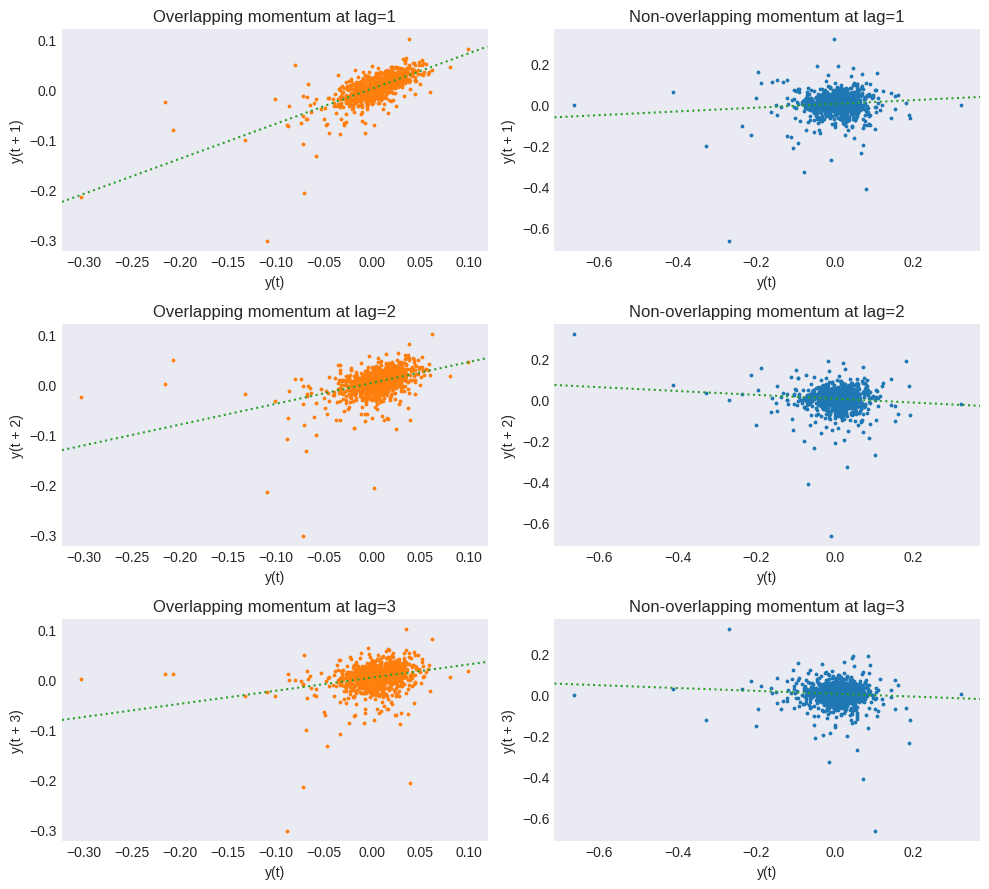

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))
for lag, ax in zip(range(1, axes.shape[0]+1, 1), axes):
    pd.plotting.lag_plot(Series(mom), lag=lag, ax=ax[0], s=3, c="C1")
    ax[0].set_title(f"Overlapping momentum at lag={lag}")
    r = scipy.stats.linregress(mom[lag:], mom[:-lag])
    ax[0].axline((0, r.intercept), slope=r.slope, ls=':', color="C2")

    pd.plotting.lag_plot(Series(jt), lag=lag, ax=ax[1], s=3, c="C0")
    ax[1].set_title(f"Non-overlapping momentum at lag={lag}")
    r = scipy.stats.linregress(jt[lag:], jt[:-lag])
    ax[1].axline((0, r.intercept), slope=r.slope, ls=':', color="C2")
plt.tight_layout()

## Hypothesis Testing

A hypothesis makes a precise statement about some population parameters; hypothesis testing can be reduced to asking how likely is the observed data if the hypothesis is true.

- The _null hypothesis_ specifies the true value of a parameter to be tested, often $H_0: \hat{\mu} = \mu_0$
- The _test statistic_ is a summary of the observed data that has a known distribution when the null hypothesis is true, e.g. $T - \dfrac{\hat{\mu} - \mu_0}{\sqrt{\sigma^2/n}} \sim N(0,1)$
- The _alternative hypothesis_ defines the range of values of the parameter where the null should be rejected, e.g. $H_a: \hat{\mu} \ne \mu_0$
  - In some testing problems, the alternative hypothesis is not the full complement of the null, for example, a _one-sided alternative_ $H_a: \hat{\mu}> \mu_0$, which is used whtn the outcome of interest is only above or below the value assumed by the null.
- The _critical value_ $C_{\alpha}$ marks the start of a range of values where the test statistic is unlikely to fall in, if the null hypthesis were true, e.g. $C_{\alpha} = \Phi^{-1}(1 - \alpha/2) = 1.96$ when $\alpha=5\%$ for a two-sided test. This range is known as the _rejection region_.
- The _size_ of the test is the probability of making a _Type I error_ of rejecting null hypothesis that is actually true. A test is said to have _significance level_ $\alpha$ if its _size_ is less than or equal to $\alpha$. This reflects the aversion to rejecting a null hypothesis that is, in fact, true.
- The _p-value_ is the probability of obtaining a test statistic at least as extreme as the one we observed from the sample, if the null hypothesis were true, e.g. $p = 2(1 - \Phi(|T|))$ for a two-sided test.



### Confidence Interval

A $1 - \alpha$ _confidence interval_ contains the values surrounding the test statistic that cannot be rejected when using a test size of $\alpha$, e.g. $[\hat{\mu} - C_{\alpha}\dfrac{\sigma^2}{\sqrt{n}}, \hat{\mu} + C_{\alpha}\dfrac{\sigma^2}{\sqrt{n}}]$ for a two-sided interval

### Newey-West corrected t-stats

Raw standard errors are understated since the standard assumption of independent observations does not apply. The Newey-West (1987) estimator requires a "maximum lag considered for the control of autocorrelation": a common choice for $L$ is the fourth root of the number of observations, e.g. Greene (Econometric Analysis, 7th edition, section 20.5.2, p. 960).

The Newey-West correction almost doubles the estimate of the standard error for the overlapping case, but a tiny adjustment for non-overlapping returns.

In [10]:
print('n =', len(mom), '   L =', math.ceil(len(mom)**(1/4)))
results = []
for rets, label in zip([mom, jt], ['Overlapping', 'Non-overlapping']):
    data = DataFrame(rets, columns=['ret'])

    # raw t-stats
    reg = smf.ols('ret ~ 1', data=data).fit()
    uncorrected = Series({stat: round(float(getattr(reg, stat).iloc[0]), 6)
                          for stat in ['params','bse','tvalues','pvalues']},
                         name='uncorrected')  # coef, stderr, t-value, P>|z|

    # Newey-West correct t-stats
    reg = smf.ols('ret ~ 1', data=data)\
             .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    corrected = Series({stat: round(float(getattr(reg, stat).iloc[0]), 6)
                        for stat in ['params','bse','tvalues','pvalues']},
                       name='NeweyWest')   # coef, stderr, t-value, P>|z|

    # merge into intermediate dataframe with multicolumn index
    df = pd.concat([uncorrected, corrected], axis=1)
    df.columns = pd.MultiIndex.from_product([[label], df.columns])
    results.append(df)

pd.concat(results, axis=1).rename_axis('Standard Errors')


n = 1170    L = 6


Overlapping           Non-overlapping          
                uncorrected NeweyWest     uncorrected NeweyWest
Standard Errors                                                
params             0.004303  0.004303        0.004399  0.004399
bse                0.000723  0.001298        0.001504  0.001474
tvalues            5.953723  3.314786        2.924986  2.984104
pvalues            0.000000  0.000917        0.003511  0.002844

__Plot cumulative monthly average returns__

Jegadeesh-Titman non-overlapping 6-month momentum portfolio returns

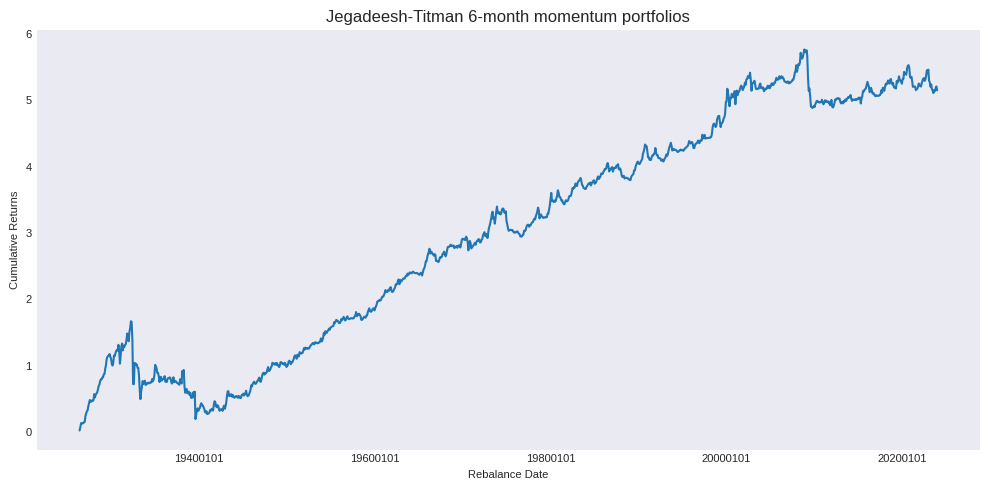

In [11]:
fig, ax = plt.subplots(figsize=(10, 5), clear=True)
plot_date(DataFrame(index=rebaldates, data=np.cumsum(jt), columns=['momentum']),
          ax=ax, fontsize=8, rotation=0,
          ylabel1='Cumulative Returns', xlabel='Rebalance Date',
          title='Jegadeesh-Titman 6-month momentum portfolios')
plt.tight_layout()
#plt.savefig(imgdir / 'jegadeesh_titman.jpg')

__Plot histogram of monthly returns__

- Jegadeesh-Titman non-overlapping 6-month momentum portfolio returns

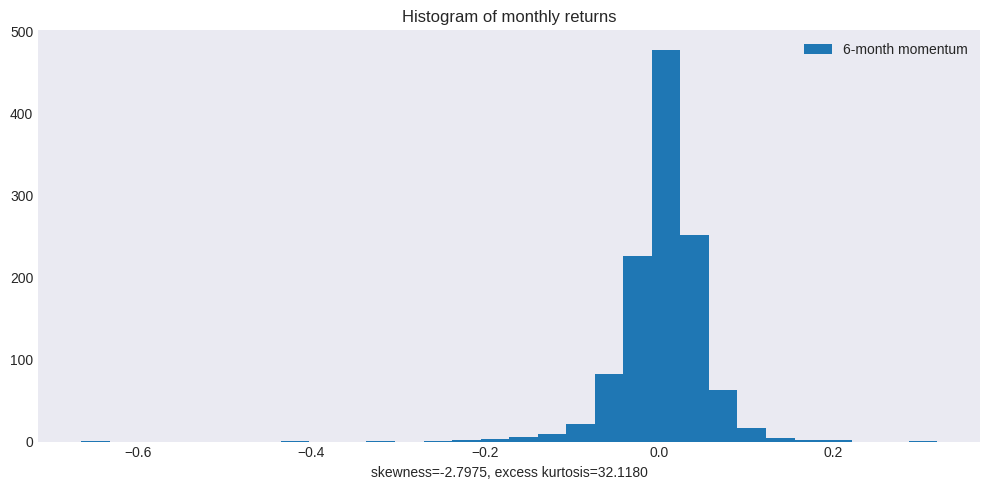

In [12]:
fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 5))
ax.hist(jt, bins=30)
ax.set_title(f"Histogram of monthly returns")
ax.legend(['6-month momentum'])
kurt = kurtosis(jt, bias=True, fisher=True)  # excess kurtosis
skewness = skew(jt, bias=True)
ax.set_xlabel(f"skewness={skewness:.4f}, excess kurtosis={kurt:.4f}")
plt.tight_layout()
#plt.savefig(imgdir / 'jegadeesh_titman_hist.jpg')

### Power of Test

A _Type II_ error occurs when the alternative is true (i.e., the null is wrong), but the null is not rejected. The probability of a Type II is denoted by $\beta$, while the _power_ of a test $1 - \beta$, specifies the probability that a false null is rejected.

Unlike the size of the test, the power of a test cannot be set and depends on the sample size, the size of the test and the distance between the true and assumed value of the parameters under the null, e.g. $1 - \beta(\alpha) = \Phi(C_{\alpha} \dfrac{\sigma^2}{\sqrt{n}}| \mu_a, \dfrac{\sigma^2}{\sqrt{n}})$ for a one-sided test $H_a: \hat{\mu} > \mu_0$.

In [23]:
DataFrame(data={"True Null": ['correct', '(1 - alpha)', 'Type I Error', 'Size: (alpha)'], 
                "False Null": ['Type II Error', '(beta)', 'correct', 'Power: (1-beta)']},
          index=['Accept Null', '', 'Reject Null', ''])\
          .rename_axis(index='Decision')

,True Null,False Null
Decision,,
Accept Null,correct,Type II Error
,(1 - alpha),(beta)
Reject Null,Type I Error,correct
,Size: (alpha),Power: (1-beta)


__Effect of Test Size (alpha) and True Alternative (mu) on Power__


In [13]:
# Assumtions
alternative = 0.06   # alternative hypothesis that annualized mean is as large as 6%
scale = np.std(jt) / np.sqrt(len(jt))  # assumed scale (std dev or volatility)

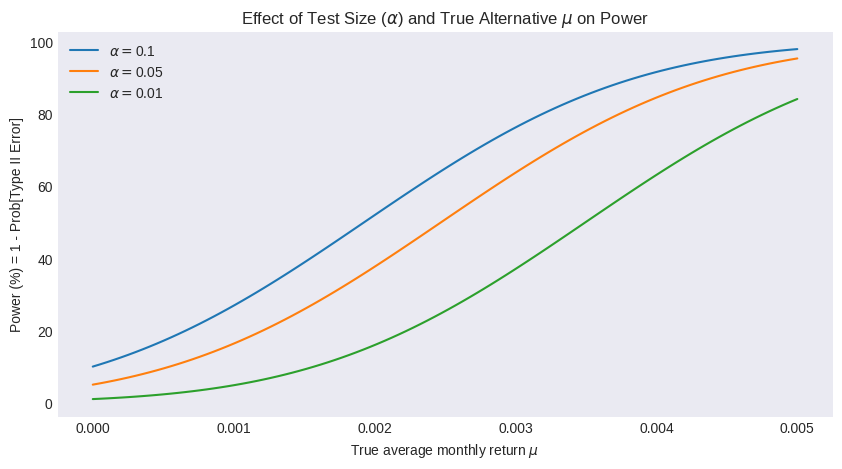

In [14]:
# Vary test size (alpha) and true mean (mu)
mu = np.linspace(0, alternative/12, 100)   # vary true mean
plt.figure(figsize=(10, 5))
for alpha in [0.1, 0.05, 0.01]:            # vary test size
    power = 1 - norm.cdf(norm.ppf(1 - alpha) * scale, loc=mu, scale=scale)
    plt.plot(mu, 100*power, label=f"$\\alpha=${alpha}")
plt.title("Effect of Test Size ($\\alpha$) and True Alternative $\\mu$ on Power")
plt.ylabel('Power (%) = 1 - Prob[Type II Error]')
plt.xlabel('True average monthly return $\\mu$')
plt.legend()

__Effect of Sample Size on Power__

In [15]:
# Assumptions
volatility = np.std(jt)
alternative = 0.06/12     # mean of the alternate hypotehsis
alpha = 0.05              # desired size of the test

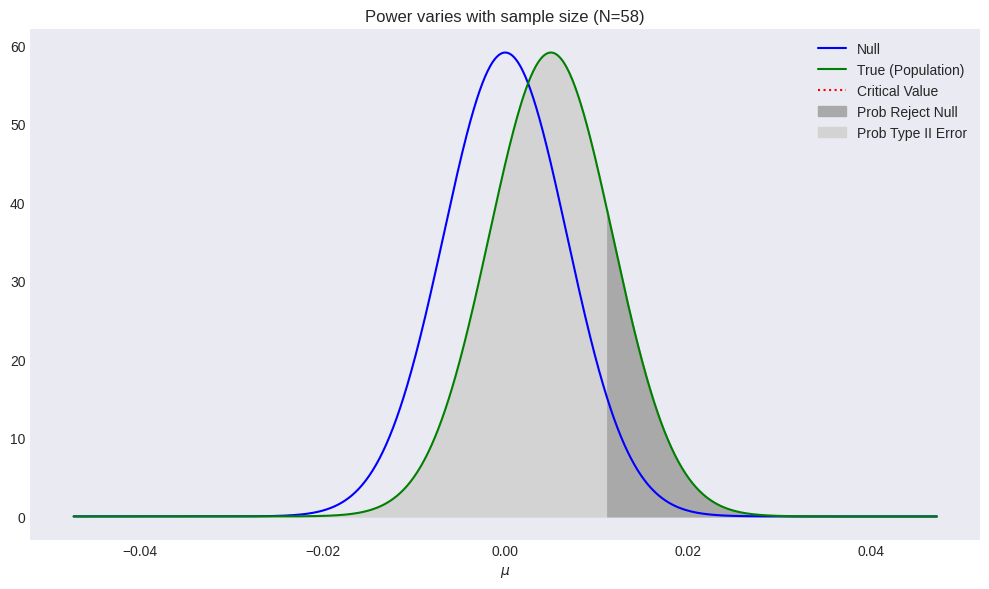

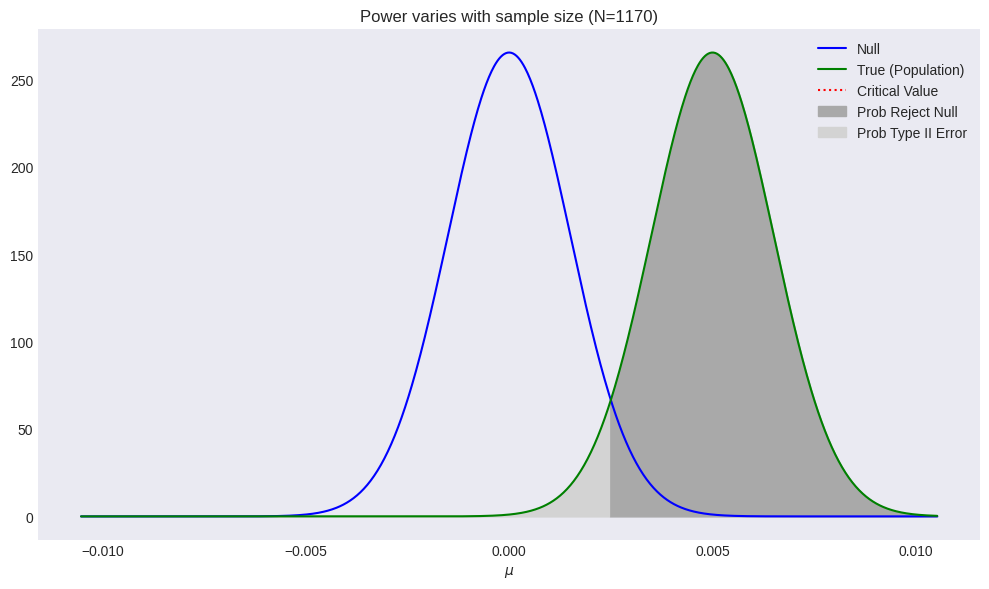

In [16]:
# Compare large and small sample sizes
for N in [len(jt) // 20, len(jt)]:

    # define null and alternate distributions given sample size 
    scale = volatility/np.sqrt(N)   # scaled by square root of sample size
    null_dist = norm(0, scale)
    alt_dist = norm(alternative, scale)
    critical_val = null_dist.ppf(1-alpha)  # critical value to reject null

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.linspace(-7 * scale, 7 * scale, 1000)
    ax.plot(x, null_dist.pdf(x), color='blue')  # plot null distribution
    ax.plot(x, alt_dist.pdf(x), color='green')  # plot alt distribution
    ylim = plt.ylim()[0]
    ax.axvline(x=critical_val, ymax=ylim, ls=':', color='r') # critical value
    px = x[x > critical_val]
    ax.fill_between(px, alt_dist.pdf(px), color='darkgrey')  # rejection region
    px = x[x < critical_val]
    ax.fill_between(px, alt_dist.pdf(px), color='lightgrey') # acceptance region
    ax.set_title(f"Power varies with sample size (N={N})")
    ax.set_xlabel("$\mu$")
    plt.legend(['Null', 'True (Population)', 'Critical Value',
                'Prob Reject Null', 'Prob Type II Error'])
    plt.tight_layout()
